In [1]:
library(ape)
library(phangorn)
library(tidyverse)
library(progress)
library(foreach)
library(doParallel)
library(glmnet)
library(SIS)
library(itertools)
library(ggtree)
library(ggplotly)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::where()  masks ape::where()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Loading required package: parallel

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked f

ERROR: Error in library(ggplotly): there is no package called ‘ggplotly’


In [2]:
lg <- list()

setwd("~/hbv_covar3/analysis/sim_seq/l100n200f128u1.25")
args <- commandArgs(trailingOnly = TRUE)
lg$run_id <- 'l100n200f128u1.25_98'
lg$ncores <- 4

lg$sim_file <- paste0("./simseq_", lg$run_id, "rescaled.fasta")
lg$log_rds_outfile <- paste0("./log_", lg$run_id, ".rds")

# parse the run ind
lg$run_ind <- tail(strsplit(lg$run_id, "_")[[1]], n = 1)
# parse the number of samples
N <- as.numeric(gsub("l.*n", "", gsub("f.*", "", lg$run_id)))

lg$tree_file <- paste0("../simseq_N", N, "_", lg$run_ind, "_rescaled.tree")
lg$outfile <- paste0("./simresult_", lg$run_id, ".txt")


In [3]:
# read in the data
message("reading data...")
msa <- seqinr::read.fasta(lg$sim_file, seqtype = "DNA")
msa <- do.call(rbind, msa)
tree <- read.tree(lg$tree_file)
colnames(msa) <- paste0("site", 1:ncol(msa))
site_ids <- colnames(msa)

# keep only the tip leaves in the msa
msa <- msa[tree$tip.label, ]

reading data...



In [4]:
      message("ancestral state reconstruction...")
        anc_restruct <- list()
        pb <- progress_bar$new(total = length(site_ids))
        for (site_id in site_ids) {
            pb$tick() # update progress
            Sys.sleep(1 / length(site_ids))
            site <- as.numeric(gsub("site", "", site_id))
            site_aas <- msa[, site]
            names(site_aas) <- rownames(msa)
            site_aas_matched <- site_aas[tree$tip.label]
            if (length(table(site_aas_matched)) == 1) next
            ace_result <- ace(site_aas_matched,
                tree,
                type = "discrete",
            )
            # add states informatino for tip nodes to anc restruct result
            tip_nodes_lik_anc <- map(site_aas_matched, function(x) {
                ifelse(colnames(ace_result$lik.anc) == x, 1, 0)
            })
            tip_nodes_lik_anc <- do.call(rbind, tip_nodes_lik_anc)
            ace_result$lik.anc <- rbind(tip_nodes_lik_anc, ace_result$lik.anc)
            anc_restruct[[site_id]] <- ace_result
        }

        

ancestral state reconstruction...


[=>---------------------------------------------------------------------]   3%

[==>--------------------------------------------------------------------]   4%

[==>--------------------------------------------------------------------]   5%

[===>-------------------------------------------------------------------]   6%

[====>------------------------------------------------------------------]   7%

[=====>-----------------------------------------------------------------]   8%

[=====>-----------------------------------------------------------------]   9%

[======>----------------------------------------------------------------]  10%

[=======>---------------------------------------------------------------]  11%

[=======>---------------------------------------------------------------]  12%

[========>--------------------------------------------------------------]  13%

[=========>-------------------------------------------------------------]  14%

[===

In [5]:
MPR(site_aas_matched, unroot(tree))

ERROR: Error in MPR(site_aas_matched, unroot(tree)): argument "outgroup" is missing, with no default


In [17]:
#########################
        # Record mutation event #
        #########################
        message("recording mutation event...")
        allele_presense_threshold <- 0.7
        allele_empty_threshold <- 0.3
        message("allele_presense_threshold: ", allele_presense_threshold)
        message("allele_empty_threshold: ", allele_empty_threshold)

        registerDoParallel(lg$ncores)
        allele_switch <- foreach(
            site_id = names(anc_restruct),
            .combine = "c"
        ) %dopar% {
            message(site_id)
            site <- as.numeric(gsub("site", "", site_id))
            cur_anc_restruct <- anc_restruct[[site_id]]$lik.anc
            lg[[paste0("anc_restruct_", site_id)]] <- cur_anc_restruct
            cur_switch_allele_tb <- matrix(NA,
                nrow = nrow(cur_anc_restruct),
                ncol = ncol(cur_anc_restruct)
            )
            colnames(cur_switch_allele_tb) <- colnames(cur_anc_restruct)
            for (node in seq_len(tree$Nnode + Ntip(tree))) {
                # get current node state
                cur_state <- which.max(cur_anc_restruct[node, ])
                if (NA %in% cur_state) next
                # get parent node state
                parent_node <- Ancestors(tree, node, "parent")
                if (parent_node == 0) next
                parent_state <- which.max(cur_anc_restruct[parent_node, ])
                # identify switch
                is_switch <- cur_state != parent_state
                cur_switch_allele_tb[node, ] <- is_switch
            }
            lg[[paste0("switch_allele_tb_", site_id)]] <- cur_switch_allele_tb
            result <- list()
            result[[site_id]] <- cur_switch_allele_tb
            result
        }

recording mutation event...

allele_presense_threshold: 0.7

allele_empty_threshold: 0.3



In [18]:
# sanity check on the results of anc reconstruction
anc_restruct$site1$lik.anc

,x,y
t181,0,1
t102,1,0
t128,1,0
t176,1,0
t195,1,0
t13,1,0
t62,1,0
t63,1,0
t77,1,0
t43,1,0


In [21]:
all_data

node,pheno,switch
<dbl>,<chr>,<chr>
1,y,yes
2,x,no
3,x,no
4,x,no
5,x,no
6,x,no
7,x,no
8,x,no
9,x,no


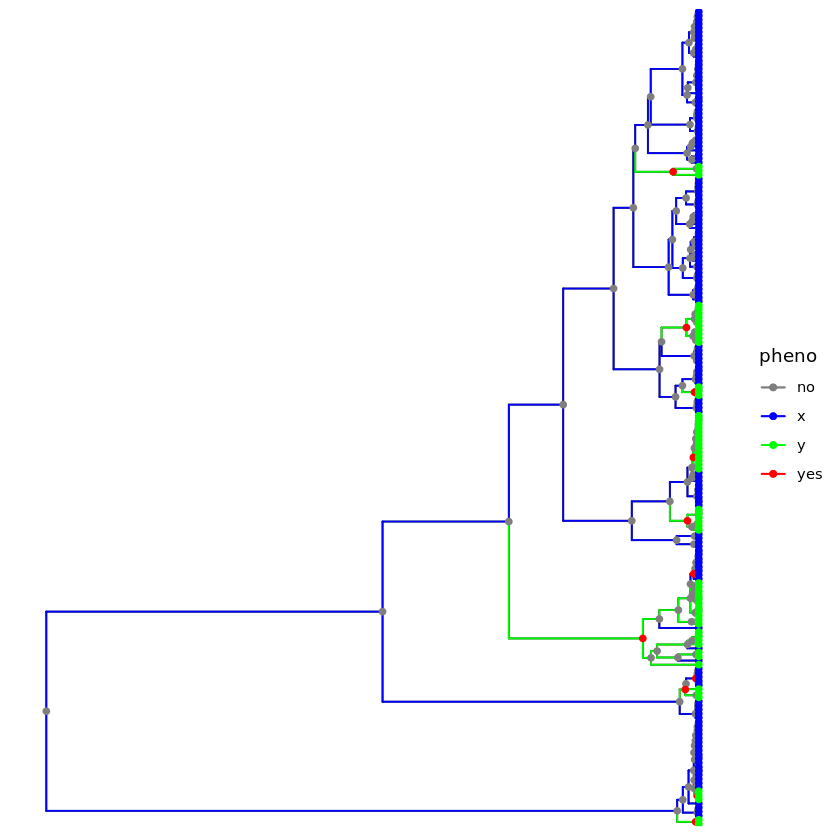

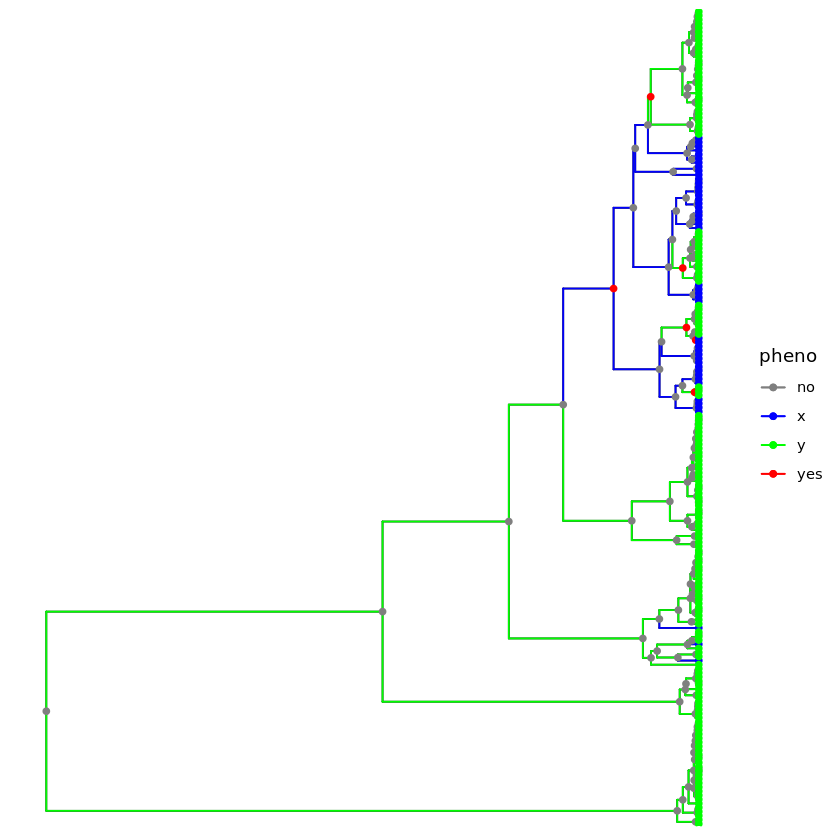

In [48]:
target_site <- 'site1'

plot_tree <- function(tree, target_site, anc_restruct, site_switch) {
    data <- data.frame(
        tip_label = rownames(msa),
        pheno = msa[, target_site]
    )
    
    edge_anc <- apply(anc_restruct[[target_site]]$lik.anc, 1, which.max)
    edge_data <- data.frame(
        node = names(edge_anc),
        pheno = edge_anc
    )
    edge_data$node <- map_dbl(edge_data$node, function(x) {
        if (grepl('t', x)){
            return(which(tree$tip.label == x))
        } else {
            return(as.numeric(x))
        }
    })
    
    site_switch <- map_dbl(allele_switch[[target_site]], 1, sum)
    switch_data <- data.frame(node = 1:length(site_switch), switch = site_switch)
    all_data <- merge(edge_data, switch_data, by = 'node')
    all_data$switch[which(all_data$switch == 0)] = 'no'
    all_data$switch[which(all_data$switch == 1)] = 'yes'
    all_data$pheno[which(all_data$pheno == 1)] = 'x'
    all_data$pheno[which(all_data$pheno == 2)] = 'y'
    
    #ggtree(tree) %<+% data + geom_tippoint(aes(color = pheno))
    p <- ggtree(tree) %<+% all_data + geom_tree(aes(color = pheno)) + 
        scale_color_manual(values = c("yes" = "red", "no" = NA, 'x' = 'blue', 'y' = 'green')) +
        geom_nodepoint(aes(color = switch, subset = !isTip)) + geom_tippoint(aes(color = pheno))
    print(p)
}
plot_tree(tree, 'site16', anc_restruct, site_switch)
plot_tree(tree, 'site47', anc_restruct, site_switch)




In [27]:
length(tree$tip.label)

[1] 200

In [13]:
allele_switch_qced$site1

x,y
FALSE,FALSE
TRUE,TRUE
TRUE,TRUE
TRUE,TRUE
TRUE,TRUE
TRUE,TRUE
TRUE,TRUE
TRUE,TRUE
TRUE,TRUE
TRUE,TRUE


In [8]:
   message("lasso regression criterion filtering...")
        # filter out alleles that do not need to be considered
        allele_switch_qced <- allele_switch
        rm_ind <- vector()
        lg$gap_filter_record <- vector()
        lg$switch_cnt_allele_filtered <- vector()
        lg$switch_cnt_site_filtered <- vector()
        for (i in seq_len(length(allele_switch))) {
            site_id <- names(allele_switch)[i]
            # can't have 99% site as gap
            lg[[paste0("allele_switch_qced_start_", site_id)]] <- 1
            site <- as.numeric(gsub("site", "", site_id))
            site_aa <- msa[, site]
            names(site_aa) <- rownames(msa)
            site_aa_matched <- site_aa[tree$tip.label]
            site_freq <- table(site_aa) / length(site_aa)
            if ("-" %in% names(site_freq)) {
                if (site_freq["-"] > 0.99) {
                    rm_ind <- c(rm_ind, i)
                    lg$gap_filter_record <- c(lg$gap_filter_record, site_id)
                    next
                }
            }
            # an allele need to have at least 3 switches
            cur_allele_switch <- allele_switch_qced[[site_id]]
            switch_cnt <- apply(cur_allele_switch, 2, function(x) sum(x, na.rm = T))
            if (length(which(switch_cnt <= 2)) != 0) {
                rm_id <- paste0(
                    site_id,
                    "_",
                    colnames(cur_allele_switch)[which(switch_cnt <= 2)]
                )
                lg$switch_cnt_filter_record <- c(lg$switch_cnt_filter_record, rm_id)
                allele_switch_qced[[site_id]] <- cur_allele_switch[, switch_cnt >= 3, drop = F]
            }
            if (ncol(allele_switch_qced[[site_id]]) == 0) {
                lg$switch_cnt_site_filtered <- c(lg$switch_cnt_site_filtered, site_id)
                rm_ind <- c(rm_ind, i)
            }
            lg[[paste0("allele_switch_qced_end_", site_id)]] <- 1
        }

        lg[[paste0("allele_switch_qced_rm_ind")]] <- rm_ind
        if (length(rm_ind) > 0) {
            allele_switch_qced <- allele_switch_qced[-rm_ind]
        }

        site_switch <- map(allele_switch_qced, function(x) {
            apply(x, 1, any)
        })
        lg$site_switch <- site_switch

       

lasso regression criterion filtering...



In [120]:
site_switch$site1

[1]  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [13] FALSE  TRUE  TRUE FALSE FALSE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE
 [25] FALSE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE FALSE  TRUE FALSE  TRUE  TRUE
 [37]  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE FALSE
 [49]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE FALSE  TRUE
 [61] FALSE  TRUE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE FALSE
 [73]  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [85]  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE
 [97] FALSE  TRUE  TRUE  TRUE    NA  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE
[109]  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[121]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE
[133]  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[145]  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE FALSE  TRUE FALSE  TRUE  TRUE
[157]  TRUE  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE
[169]  TRUE  TRUE  TRUE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[181]  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE
[193]  TRUE  TRUE FALSE FALSE  TRUE  TRUE  TRUE

In [121]:
 message("lasso regression...")
        # get tree length
        nodes_n <- tree$Nnode + length(tree$tip.label)
        root_node <- setdiff(1:nodes_n, tree$edge[, 2])
        edge_length <- rep(NA, nodes_n)
        edge_length[tree$edge[, 2]] <- tree$edge.length
        registerDoParallel(lg$ncores)
        iterate_chunks <- isplitVector(seq_len(length(site_switch)), chunks = lg$ncores)

        if (length(site_switch) <= 1){
            result <- NULL
        } else {
            result <- foreach(chunk = iterate_chunks) %dopar% {
                cur_result <- list()
                for (i in chunk) {
                    message(i)
                    site_id <- names(site_switch)[i]
                    # if (length(site_id) <= 1) {
                    #     # there is less than two sites, association not possible 
                    #     return(NULL)
                    # }
                    # fuse the nodes together
                    site_switch_fused <- site_switch
                    dep_sites <- names(site_switch_fused)[-which(names(site_switch_fused) %in% site_id)]
                    dep_sites <- do.call(cbind, site_switch_fused[dep_sites])
                    dep_sites <- apply(dep_sites, 2, as.numeric)
                    data <- cbind(site_switch[[site_id]], edge_length, dep_sites)
                    # remove cols/rows with too many NA
                    rm_row <- unlist(apply(data, 1, function(x) {
                        freq <- sum(is.na(x)) / length(x)
                        if (freq > 0.1) {
                            return(T)
                        } else {
                            return(F)
                        }
                    }))

                    rm_col <- unlist(apply(data, 2, function(x) {
                        freq <- sum(is.na(x)) / length(x)
                        if (freq > 0.1) {
                            return(T)
                        } else {
                            return(F)
                        }
                    }))
                    if (length(rm_row)) {
                        data <- data[!(rm_row), !(rm_col)]
                    }
                    y <- data[, 1]
                    x <- data[, -1, drop = F]
                    mysd <- function(y) sqrt(sum((y - mean(y))^2) / length(y))
                    sx <- scale(x, scale = apply(x, 2, mysd))
                    start_lambda <- max(abs(colSums(sx * y))) / nrow(x)
                    # add 100 lambdas before start lambda for warm up
                    lambdas <- map_dbl(1:100, function(i) start_lambda * (1 / 0.99)^(i - 1))
                    lambdas <- c(lambdas, map_dbl(1:687, function(i) start_lambda * (0.99)^(i - 1)))
                    lambdas <- sort(lambdas)
                    cur_result[[site_id]] <- glmnet(data[, -1], data[, 1], family = "binomial", lambda = lambdas)
                    # select beta via ebic
                    ebic <- map_dbl(1:length(cur_result[[site_id]]$lambda), function(j) {
                        lambda <- cur_result[[site_id]]$lambda[j]
                        cur_ebic <- deviance(cur_result[[site_id]])[j] +
                            sum(cur_result[[site_id]]$beta[, j] != 0) * log(nrow(data)) +
                            2 * log(choose(ncol(data[, -1]), sum(cur_result[[site_id]]$beta[, j] != 0)))
                    })
                    min.ind <- which.min(ebic)
                    beta_col <- cur_result[[site_id]]$beta[, min.ind]
                    # message(paste0("beta_col: ", beta_col))
                    beta <- names(beta_col)[which(beta_col != 0)]
                    cur_result[[site_id]]$selected_beta <- beta
                }
                return(cur_result)
            }

            result <- unlist(result, recursive = F)
        }

lasso regression...



In [125]:
which(names(site_switch_fused) %in% site_id)
names(site_switch_fused)

[1] 103

[1] "site1"   "site2"   "site3"   "site4"   "site5"   "site6"   "site7"  
  [8] "site8"   "site9"   "site10"  "site11"  "site12"  "site13"  "site14" 
 [15] "site15"  "site16"  "site17"  "site18"  "site19"  "site20"  "site21" 
 [22] "site22"  "site23"  "site24"  "site25"  "site26"  "site27"  "site28" 
 [29] "site29"  "site30"  "site31"  "site32"  "site33"  "site34"  "site35" 
 [36] "site36"  "site37"  "site38"  "site39"  "site40"  "site41"  "site42" 
 [43] "site43"  "site44"  "site45"  "site46"  "site47"  "site48"  "site49" 
 [50] "site50"  "site51"  "site52"  "site53"  "site54"  "site55"  "site56" 
 [57] "site57"  "site58"  "site59"  "site60"  "site61"  "site62"  "site63" 
 [64] "site64"  "site65"  "site66"  "site67"  "site68"  "site69"  "site70" 
 [71] "site71"  "site72"  "site73"  "site74"  "site75"  "site76"  "site77" 
 [78] "site78"  "site79"  "site80"  "site81"  "site82"  "site83"  "site84" 
 [85] "site85"  "site86"  "site87"  "site88"  "site89"  "site90"  "site91" 
 [92] "site92"  "site93"  "site94"  "site95"  "site96"  "site97"  "site98" 
 [99] "site99"  "site100" "site101" "site102" "site103"

In [133]:
i <- 1
site_id <- names(site_switch)[i]
site_switch_fused <- site_switch
dep_sites <- names(site_switch_fused)[-which(names(site_switch_fused) %in% site_id)]
dep_sites <- do.call(cbind, site_switch_fused[dep_sites])
dep_sites <- apply(dep_sites, 2, as.numeric)
data <- cbind(site_switch[[site_id]], edge_length, dep_sites)

# remove cols/rows with too many NA
                    rm_row <- unlist(apply(data, 1, function(x) {
                        freq <- sum(is.na(x)) / length(x)
                        if (freq > 0.1) {
                            return(T)
                        } else {
                            return(F)
                        }
                    }))

                    rm_col <- unlist(apply(data, 2, function(x) {
                        freq <- sum(is.na(x)) / length(x)
                        if (freq > 0.1) {
                            return(T)
                        } else {
                            return(F)
                        }
                    }))

if (length(rm_row)) {
                        data <- data[!(rm_row), !(rm_col)]
                    }


y <- data[, 1]
                    x <- data[, -1, drop = F]
                    mysd <- function(y) sqrt(sum((y - mean(y))^2) / length(y))
                    sx <- scale(x, scale = apply(x, 2, mysd))
                    start_lambda <- max(abs(colSums(sx * y))) / nrow(x)
                    # add 100 lambdas before start lambda for warm up
                    lambdas <- map_dbl(1:100, function(i) start_lambda * (1 / 0.99)^(i - 1))
                    lambdas <- c(lambdas, map_dbl(1:687, function(i) start_lambda * (0.99)^(i - 1)))
                    lambdas <- sort(lambdas)


In [167]:
length(lambdas)

[1] 787

In [178]:
test <- glmnet(data[, -1], data[, 1], family = "binomial", lambda = lambdas[1:00])
test2 <- glmnet(data[, -1], data[, 1], family = "binomial", lambda = lambdas)
test$beta[, 2]
test2$beta[, 2]


edge_length       site2       site3       site4       site5       site6 
          0           0           0           0           0           0 
      site7       site8       site9      site10      site11      site12 
          0           0           0           0           0           0 
     site13      site14      site15      site16      site17      site18 
          0           0           0           0           0           0 
     site19      site20      site21      site22      site23      site24 
          0           0           0           0           0           0 
     site25      site26      site27      site28      site29      site30 
          0           0           0           0           0           0 
     site31      site32      site33      site34      site35      site36 
          0           0           0           0           0           0 
     site37      site38      site39      site40      site41      site42 
          0           0           0           0           0           0 
     site43      site44      site45      site46      site47      site48 
          0           0           0           0           0           0 
     site49      site50      site51      site52      site53      site54 
          0           0           0           0           0           0 
     site55      site56      site57      site58      site59      site60 
          0           0           0           0           0           0 
     site61      site62      site63      site64      site65      site66 
          0           0           0           0           0           0 
     site67      site68      site69      site70      site71      site72 
          0           0           0           0           0           0 
     site73      site74      site75      site76      site77      site78 
          0           0           0           0           0           0 
     site79      site80      site81      site82      site83      site84 
          0           0           0           0           0           0 
     site85      site86      site87      site88      site89      site90 
          0           0           0           0           0           0 
     site91      site92      site93      site94      site95      site96 
          0           0           0           0           0           0 
     site97      site98      site99     site100     site101     site102 
          0           0           0           0           0           0 
    site103 
          0

edge_length       site2       site3       site4       site5       site6 
          0           0           0           0           0           0 
      site7       site8       site9      site10      site11      site12 
          0           0           0           0           0           0 
     site13      site14      site15      site16      site17      site18 
          0           0           0           0           0           0 
     site19      site20      site21      site22      site23      site24 
          0           0           0           0           0           0 
     site25      site26      site27      site28      site29      site30 
          0           0           0           0           0           0 
     site31      site32      site33      site34      site35      site36 
          0           0           0           0           0           0 
     site37      site38      site39      site40      site41      site42 
          0           0           0           0           0           0 
     site43      site44      site45      site46      site47      site48 
          0           0           0           0           0           0 
     site49      site50      site51      site52      site53      site54 
          0           0           0           0           0           0 
     site55      site56      site57      site58      site59      site60 
          0           0           0           0           0           0 
     site61      site62      site63      site64      site65      site66 
          0           0           0           0           0           0 
     site67      site68      site69      site70      site71      site72 
          0           0           0           0           0           0 
     site73      site74      site75      site76      site77      site78 
          0           0           0           0           0           0 
     site79      site80      site81      site82      site83      site84 
          0           0           0           0           0           0 
     site85      site86      site87      site88      site89      site90 
          0           0           0           0           0           0 
     site91      site92      site93      site94      site95      site96 
          0           0           0           0           0           0 
     site97      site98      site99     site100     site101     site102 
          0           0           0           0           0           0 
    site103 
          0

In [147]:
cur_result <- list()
cur_result[[site_id]] <- glmnet(data[, -1], data[, 1], family = "binomial", lambda = lambdas)

ebic <- map_dbl(1:length(cur_result[[site_id]]$lambda), function(j) {
                        lambda <- cur_result[[site_id]]$lambda[j]
                        cur_ebic <- deviance(cur_result[[site_id]])[j] +
                            sum(cur_result[[site_id]]$beta[, j] != 0) * log(nrow(data)) +
                            2 * log(choose(ncol(data[, -1]), sum(cur_result[[site_id]]$beta[, j] != 0)))
                    })
                    min.ind <- which.min(ebic)

In [159]:
beta_col <- cur_result[[site_id]]$beta[, min.ind]
                    # message(paste0("beta_col: ", beta_col))
                    beta <- names(beta_col)[which(beta_col != 0)]
                    cur_result[[site_id]]$selected_beta <- beta
min.ind

[1] 2

In [157]:
test2 <- 

  [[ suppressing 787 column names 's0', 's1', 's2' ... ]]



103 x 787 sparse Matrix of class "dgCMatrix"
                                                                               
edge_length . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
site2       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
site3       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
site4       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
site5       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
site6       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
site7       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
site8       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
site9       . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
site10      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
site11      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [114]:
  # check result
        assoc_pair <- list()
        lst_ind <- 1
        for (i in 1:length(result)) {
            cur_assoc_sites <- result[[i]]$selected_beta
            if (length(cur_assoc_sites) != 0) {
                for (cur_assoc_site in cur_assoc_sites) {
                    assoc_pair[[lst_ind]] <- c(names(result)[i], cur_assoc_site)
                    lst_ind <- lst_ind + 1
                }
            }
        }
        assoc_pair <- do.call(rbind, assoc_pair)

In [115]:
assoc_pair

NULL

In [43]:
all_data

node,pheno.x,pheno.y
<dbl>,<int>,<dbl>
1,1,0
2,1,0
3,2,0
4,2,0
5,2,0
6,2,0
7,2,0
8,2,0
9,2,0
